In [29]:
library(data.table)
library(dplyr)
library(redeemR)
library(stringr)
library(BuenColors)
library(ggtree)
library(ape)
library(phangorn)
library(castor)
library(ggtreeExtra)
library(parallel)
source('00_functions.R')

Loading required package: Rcpp



In [2]:
# example
base_dir = '/Users/tgao/redeem/'

id <- "Young1.T1.BMMC"
print(id)
WD <-  paste0(base_dir, id, ".Consensus.final/") # CL specific working directory

# Import data based on reproducibility notebook
redeemR<-Create_redeemR(redeemR.read(path=WD,thr="S",Processed=T,rdsname = "/new.VariantsGTSummary.RDS"))
redeemR@HomoVariants <- (redeemR@V.fitered %>% filter(totalVAF > 0.35) %>% pull(Variants)) # Variants in Old 2 that are at 40%

(redeemR@V.fitered %>% filter(totalVAF > 0.35) %>% filter(HomoTag != "Homo"))

[1] "Young1.T1.BMMC"
[1] "41114 variants to start"
[1] "40728 variants after remove low quality cells"
 [1] "Tag Homoplasmy: 11674_C_T" "Tag Homoplasmy: 11719_G_A"
 [3] "Tag Homoplasmy: 11947_A_G" "Tag Homoplasmy: 12414_T_C"
 [5] "Tag Homoplasmy: 1243_T_C"  "Tag Homoplasmy: 12705_C_T"
 [7] "Tag Homoplasmy: 12923_G_T" "Tag Homoplasmy: 1406_T_C" 
 [9] "Tag Homoplasmy: 1438_A_G"  "Tag Homoplasmy: 14766_C_T"
[11] "Tag Homoplasmy: 15326_A_G" "Tag Homoplasmy: 15884_G_C"
[13] "Tag Homoplasmy: 16223_C_T" "Tag Homoplasmy: 16292_C_T"
[15] "Tag Homoplasmy: 16519_T_C" "Tag Homoplasmy: 194_C_T"  
[17] "Tag Homoplasmy: 195_T_C"   "Tag Homoplasmy: 199_T_C"  
[19] "Tag Homoplasmy: 204_T_C"   "Tag Homoplasmy: 207_G_A"  
[21] "Tag Homoplasmy: 263_A_G"   "Tag Homoplasmy: 2706_A_G" 
[23] "Tag Homoplasmy: 3505_A_G"  "Tag Homoplasmy: 4769_A_G" 
[25] "Tag Homoplasmy: 5046_G_A"  "Tag Homoplasmy: 5460_G_A" 
[27] "Tag Homoplasmy: 7028_C_T"  "Tag Homoplasmy: 7058_T_C" 
[29] "Tag Homoplasmy: 709_G_A"   "Tag Homop

Variants CellN PositiveMean maxcts CellNPCT  TotalVcount TotalCov totalVAF 
1 310_T_C  5001  0.5077709    31     0.8294908 15473       43909.52 0.3523837
  CV        HomoTag
1 0.1094584 Hetero

In [4]:
# Append the variants that Chen manually filters out already as homoplasmic
# so they aren't in the matrix
redeemR@HomoVariants <- c(redeemR@HomoVariants, bad_vars_cw)

# Create matrix using redeem functions
redeemR <- Make_matrix(redeemR)

## Filter low coverage cells
BadCells<-subset(redeemR@CellMeta,meanCov<10)$Cell
keep_cells <- !(rownames(redeemR@Cts.Mtx.bi) %in% BadCells)

Only heteroplasmic mutations are used

@Cts.Mtx and @Cts.Mtx.bi are added



In [5]:
df_annot = fread(paste0('../data/', id, '.var.annot.csv'))

In [6]:
# Now compute the binary matrix under two sets of circumstances
# https://github.com/chenweng1991/redeemR/blob/master/R/BuidTree.R#L237

Cts.Mtx.bin1 <- redeemR@Cts.Mtx[keep_cells,]
Cts.Mtx.bin1[Cts.Mtx.bin1>=1]<-1

Cts.Mtx.bin2 <- redeemR@Cts.Mtx[keep_cells,]
Cts.Mtx.bin2[Cts.Mtx.bin2 <= 1]<-0
Cts.Mtx.bin2[Cts.Mtx.bin2 >= 2]<-1

# Now compute cell - cell connectivity
# Use matrix multiplication approach from CW: https://github.com/chenweng1991/redeem_reproducibility/blob/master/Issue%231.ipynb

cell_cell_connectivity1 <- (Cts.Mtx.bin1 %*% t(Cts.Mtx.bin1)) >= 2
diag(cell_cell_connectivity1) <- 0

cell_cell_connectivity2 <- (Cts.Mtx.bin2 %*% t(Cts.Mtx.bin2)) >= 2
diag(cell_cell_connectivity2) <- 0

cell_cell_connectivity3 <- (Cts.Mtx.bin1 %*% t(Cts.Mtx.bin1)) >= 1
diag(cell_cell_connectivity3) <- 0

# Summarize what happens
pct_connections_lost <- (sum(cell_cell_connectivity1) - sum(cell_cell_connectivity2))/sum(cell_cell_connectivity1)*100

D = data.frame(id, 
         original_connections = sum(cell_cell_connectivity1),
         connections_after_filter1 = sum(cell_cell_connectivity2),
         connections_wOnly1 = sum(cell_cell_connectivity3), n_cells = sum(keep_cells),
         pct_connections_lost = round(pct_connections_lost, 2))

In [8]:
vars_lmhc = df_annot %>% filter(color == 'redeemProblem') %>% pull(variant_alias)

In [9]:
Cts.Mtx.bin3 = Cts.Mtx.bin1
Cts.Mtx.bin3 = Cts.Mtx.bin3[,!colnames(Cts.Mtx.bin3) %in% vars_lmhc]

cell_cell_connectivity4 <- (Cts.Mtx.bin3 %*% t(Cts.Mtx.bin3)) >= 2
diag(cell_cell_connectivity4) <- 0

In [10]:
cell_cell_connectivity_a <- (Cts.Mtx.bin1 %*% t(Cts.Mtx.bin1)) >= 2
diag(cell_cell_connectivity_a) <- 0

cell_cell_connectivity_b <- (Cts.Mtx.bin2 %*% t(Cts.Mtx.bin2)) >= 2
diag(cell_cell_connectivity_b) <- 0

cell_cell_connectivity_c <- (Cts.Mtx.bin3 %*% t(Cts.Mtx.bin3)) >= 2
diag(cell_cell_connectivity_c) <- 0

sum(cell_cell_connectivity_a)
sum(cell_cell_connectivity_b)
sum(cell_cell_connectivity_c)

[1] 221320

[1] 156

[1] 6756

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


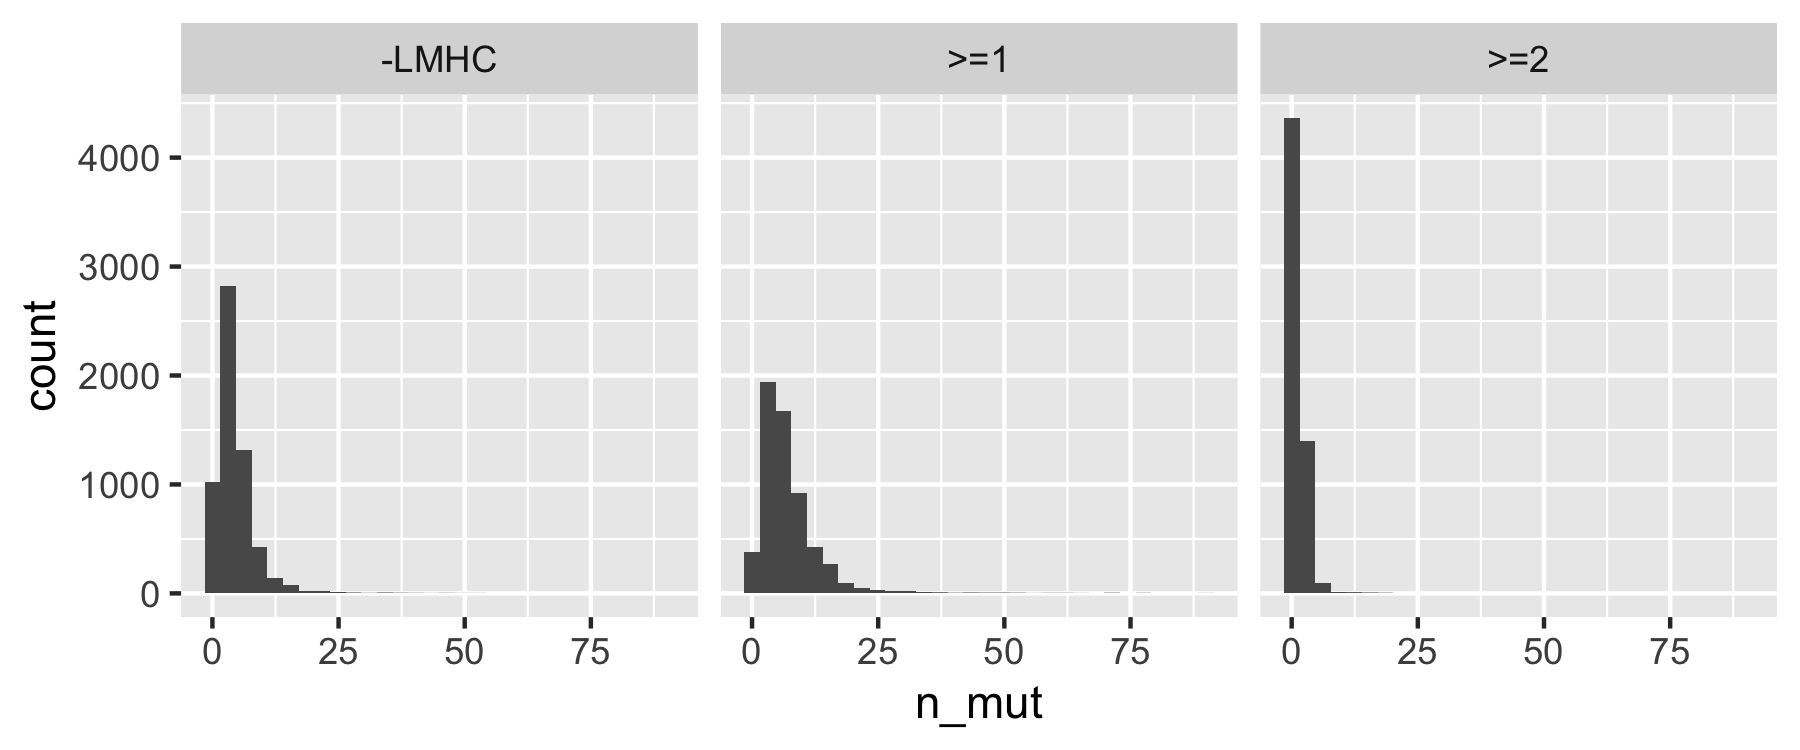

In [11]:
options(repr.plot.width = 6, repr.plot.height = 2.5, repr.plot.res = 300)

mats = list('>=1' = Cts.Mtx.bin1, '>=2' = Cts.Mtx.bin2, '-LMHC' = Cts.Mtx.bin3)

lapply(
    names(mats),
    function(x) {
        rowSums(mats[[x]]) %>% data.frame() %>%
        tibble::rownames_to_column('cell') %>% 
        setNames(c('cell', 'n_mut')) %>%
        mutate(mat = x)
    }
) %>%
bind_rows() %>%
ggplot(
    aes(x = n_mut)
) +
geom_histogram() +
facet_wrap(~mat)

In [12]:
rowSums(cell_cell_connectivity_a) %>% summary
rowSums(cell_cell_connectivity_b) %>% summary
rowSums(cell_cell_connectivity_c) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    5.00   37.65   47.00  825.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.02654 0.00000 8.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   1.149   1.000  52.000 

In [13]:
# function to make the weights for their jaccard thingy
make_weight_df <- function(Cts.bin){
    # Pull out weights fromt the data object; update with N/As with 1 as described in manuscript
    weightdf<-data.frame(Variants=colnames(Cts.bin)) %>% merge(.,V.weight,by="Variants",all.x = T,sort = F) 
    weight <- weightdf %>% pull(weight)
    weight[is.na(weight)] <- 1
    weight
}

# do the weights
weight1 <- make_weight_df(Cts.Mtx.bin1)
weight2 <- make_weight_df(Cts.Mtx.bin2)
weight3 <- make_weight_df(Cts.Mtx.bin3)

# Compute weighted jaccard distance metric in the paper
w_j1 <- quick_w_jaccard_cl(Cts.Mtx.bin1,weight1) %>% data.matrix()
w_j2 <- quick_w_jaccard_cl(Cts.Mtx.bin2,weight2) %>% data.matrix()
w_j3 <- quick_w_jaccard_cl(Cts.Mtx.bin3,weight3) %>% data.matrix()

In [16]:
phylo1 <- nj(w_j1)
message('tree1')

tree1



In [23]:
phylo2 <- nj(w_j2)
message('tree2')

tree2



In [14]:
phylo3 <- nj(w_j3)
message('tree3')

tree3



Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


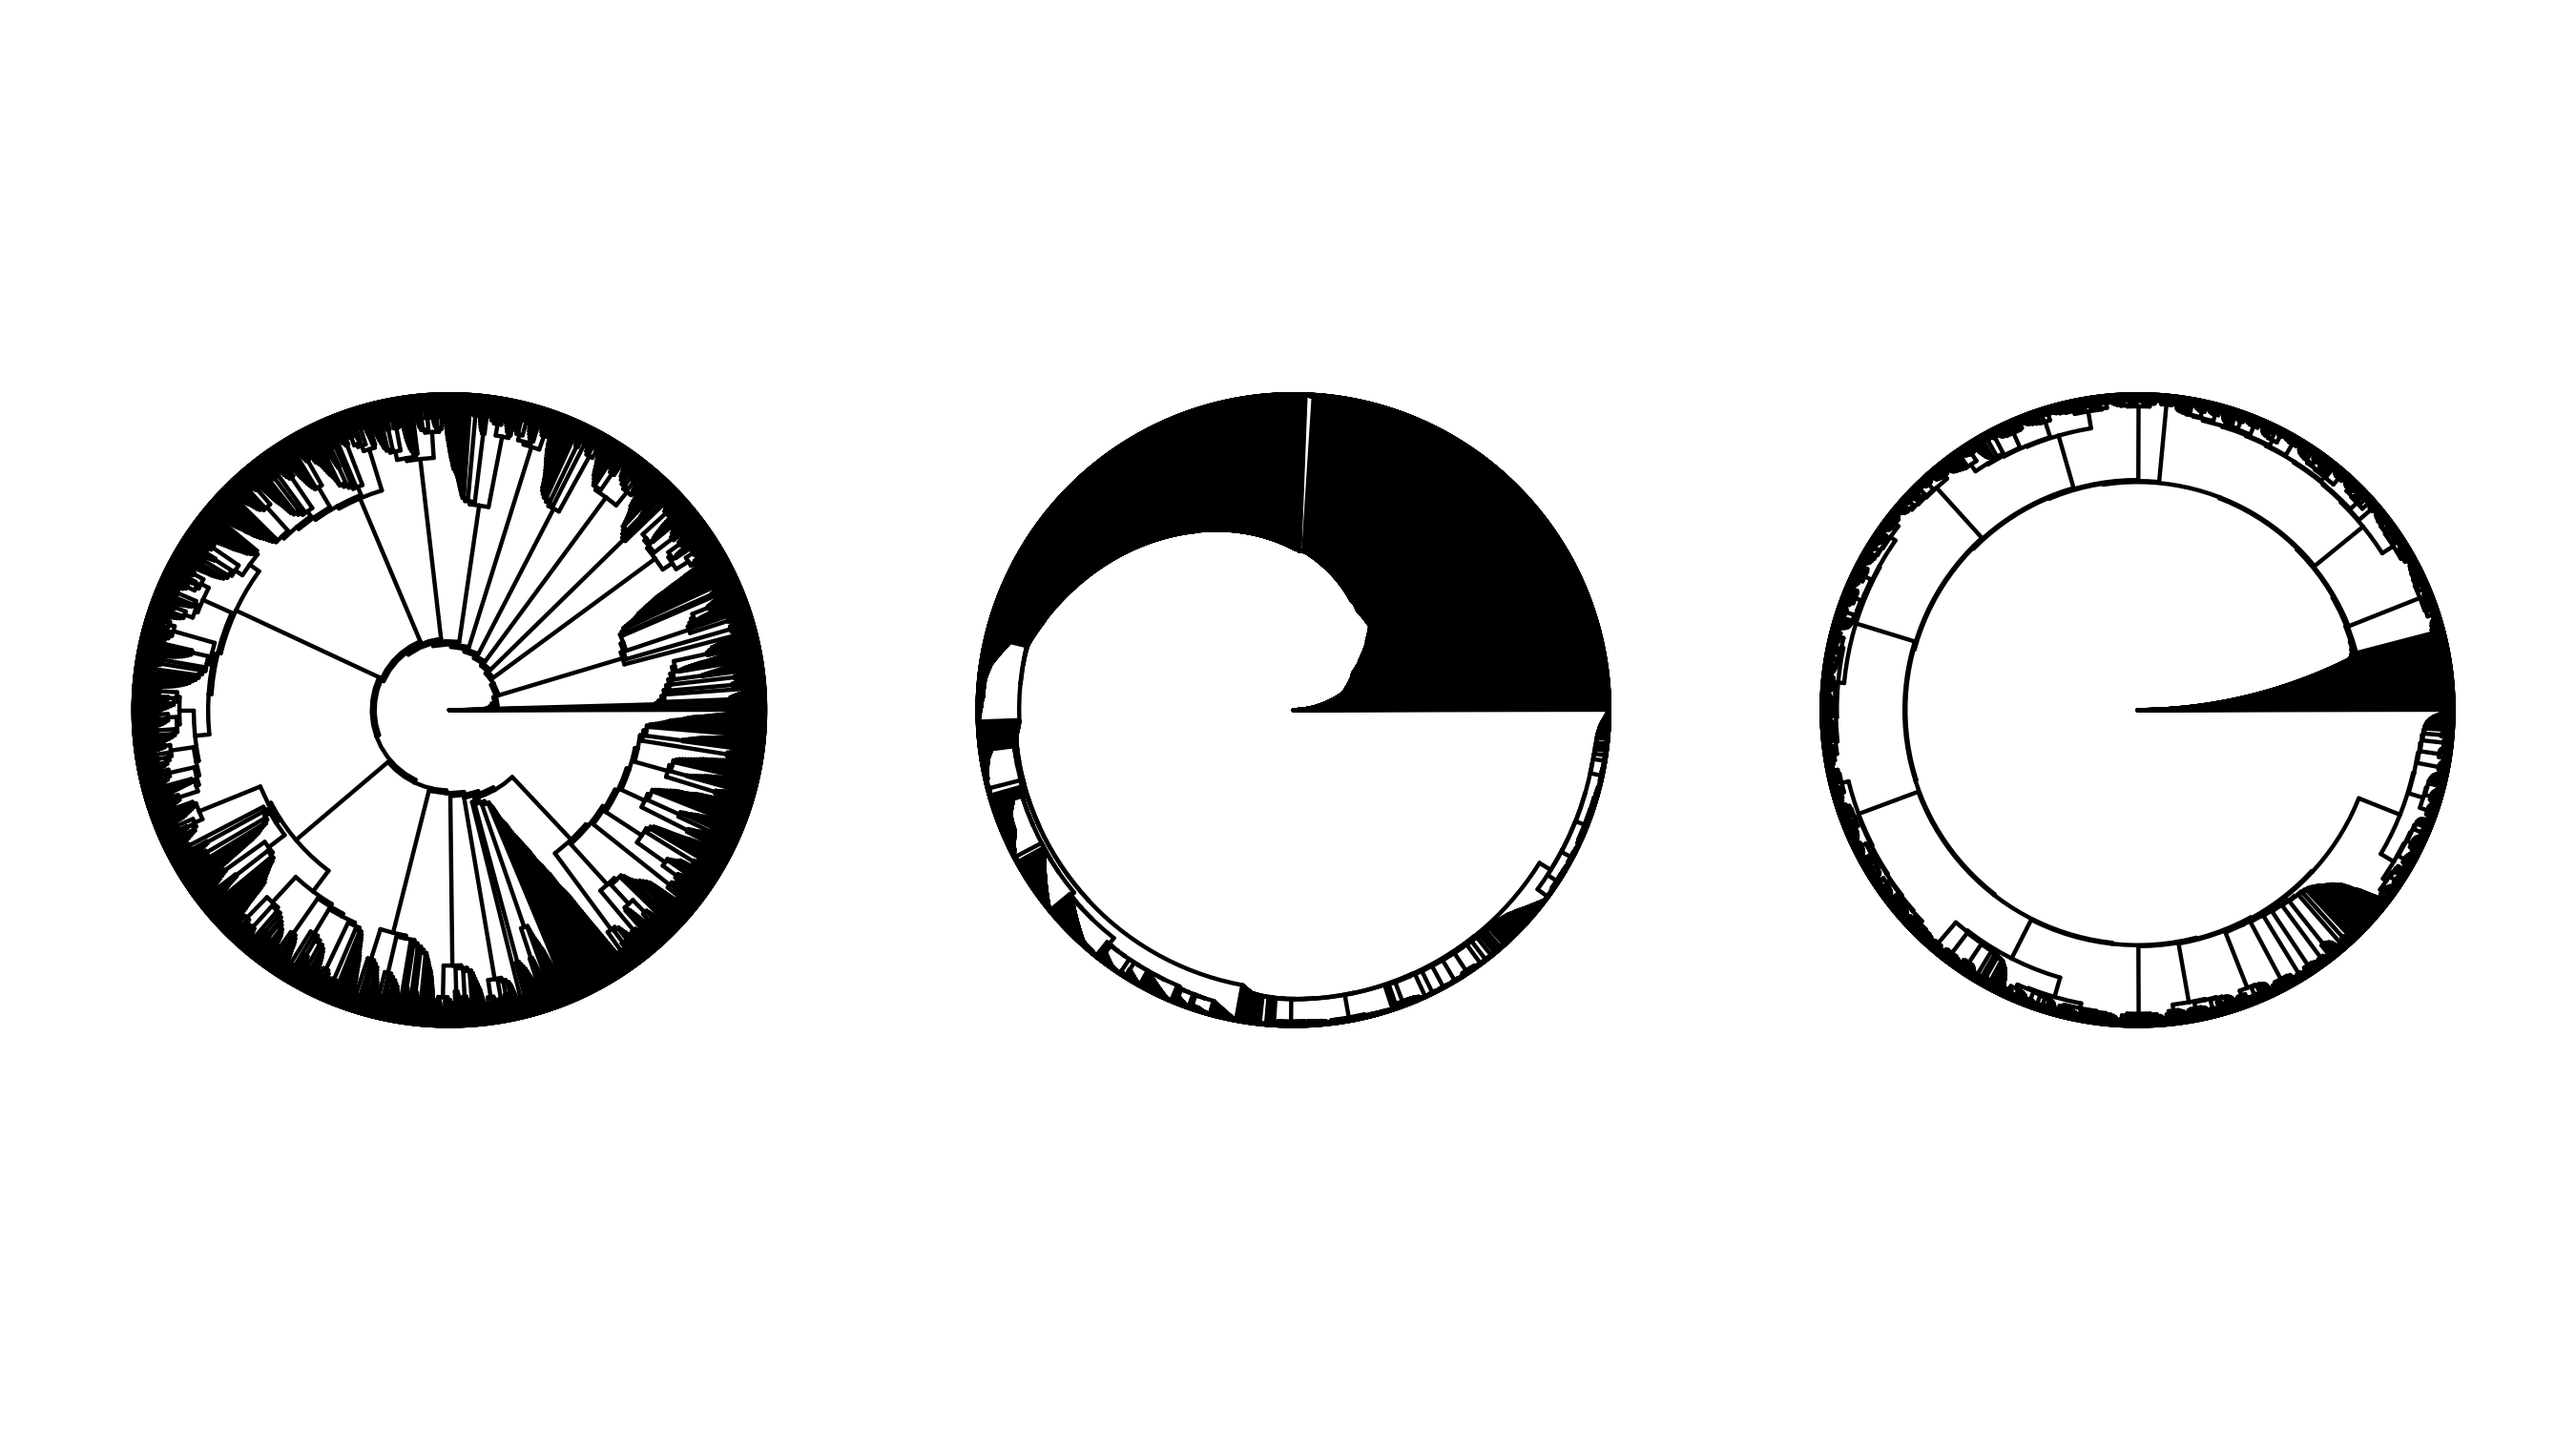

In [27]:
options(repr.plot.width = 9, repr.plot.height = 4, repr.plot.res = 300)

p1 = ggtree(phylo1,layout="fan", branch.length = 'none')
p2 = ggtree(phylo2,layout="fan", branch.length = 'none')
p3 = ggtree(phylo3,layout="fan", branch.length = 'none')

p1 | p2 | p3

In [18]:
t1 <- ggtree(phylo1,layout="fan", branch.length='none')
  ncell <- length(get_taxa_name(t1))
  clmdf <- data.frame(
    Cell = get_taxa_name(t1),
    idx = 1:(ncell),
    val = 1:(ncell)/(ncell)
  )
  
# Make first tree
t1f <- t1 + geom_fruit( 
    data=clmdf, 
    geom=geom_tile, 
    mapping=aes(y=Cell,x=2,fill=val), 
    pwidth=0.001, 
    width=10, 
    offset=0.05
) + scale_fill_gradientn(colors = jdb_palette("brewer_spectra")) + theme(legend.position = "none")
  
# Make new tree after filtering
t2 <- ggtree(phylo3,layout="fan", branch.length='none')

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


In [24]:
process_tree_MRCA <- function(t1, t2, nrep = 10, npair = 1000){
    n_nodes <- t1$Nnode
    
    mclapply(1:nrep, mc.cores = 10, function(j){
      lapply(1:npair, function(i){
        set.seed(i+j*50000)
        random3 <- sort(sample(1:n_nodes, size = 3))
        eg <- expand.grid(random3, random3) %>%
          filter(Var1 < Var2)
        d1 <- get_pairwise_distances(t1, A = eg[,1], B= eg[,2])
        d2 <- get_pairwise_distances(t2, A = eg[,1], B= eg[,2])
        data.frame(idx = i,
                   perm = j,
                   match = which.min(d1) == which.min(d2))
      }) %>% rbindlist() %>% data.frame() -> odf
      odf
    }) %>% rbindlist() %>% data.frame() ->  full_df
    full_df
  }

In [30]:
res_1v3 = process_tree_MRCA(phylo1, phylo3, nrep = 10, npair = 1000)
res_1v2 = process_tree_MRCA(phylo1, phylo2, nrep = 10, npair = 1000)

In [ ]:
res_1v3 %>% group_by(perm) %>% summarise(prop = mean(match)) %>% pull(prop) %>% summary
res_1v2 %>% group_by(perm) %>% summarise(prop = mean(match)) %>% pull(prop) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4430  0.4532  0.4600  0.4622  0.4723  0.4830 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3280  0.3422  0.3495  0.3482  0.3568  0.3620 

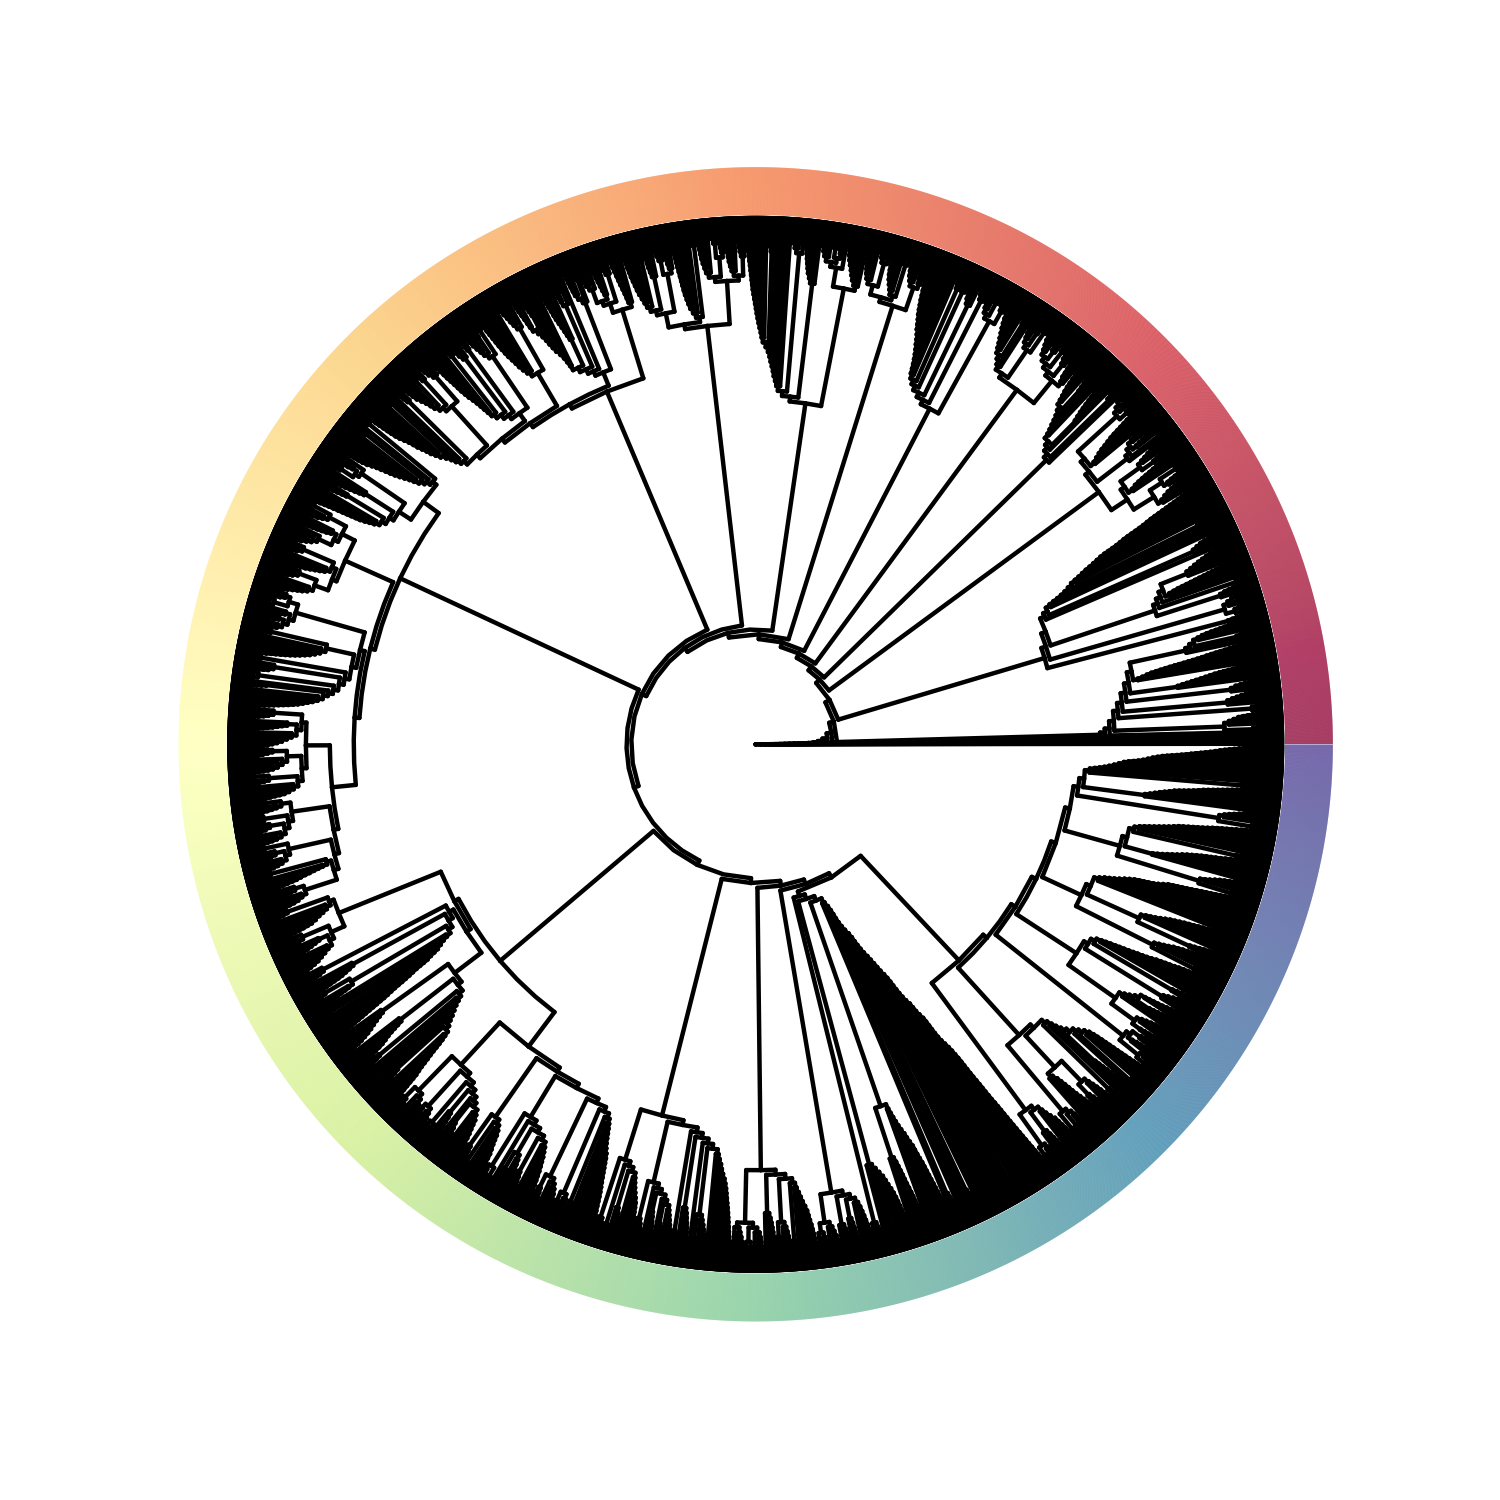

In [19]:
t1f

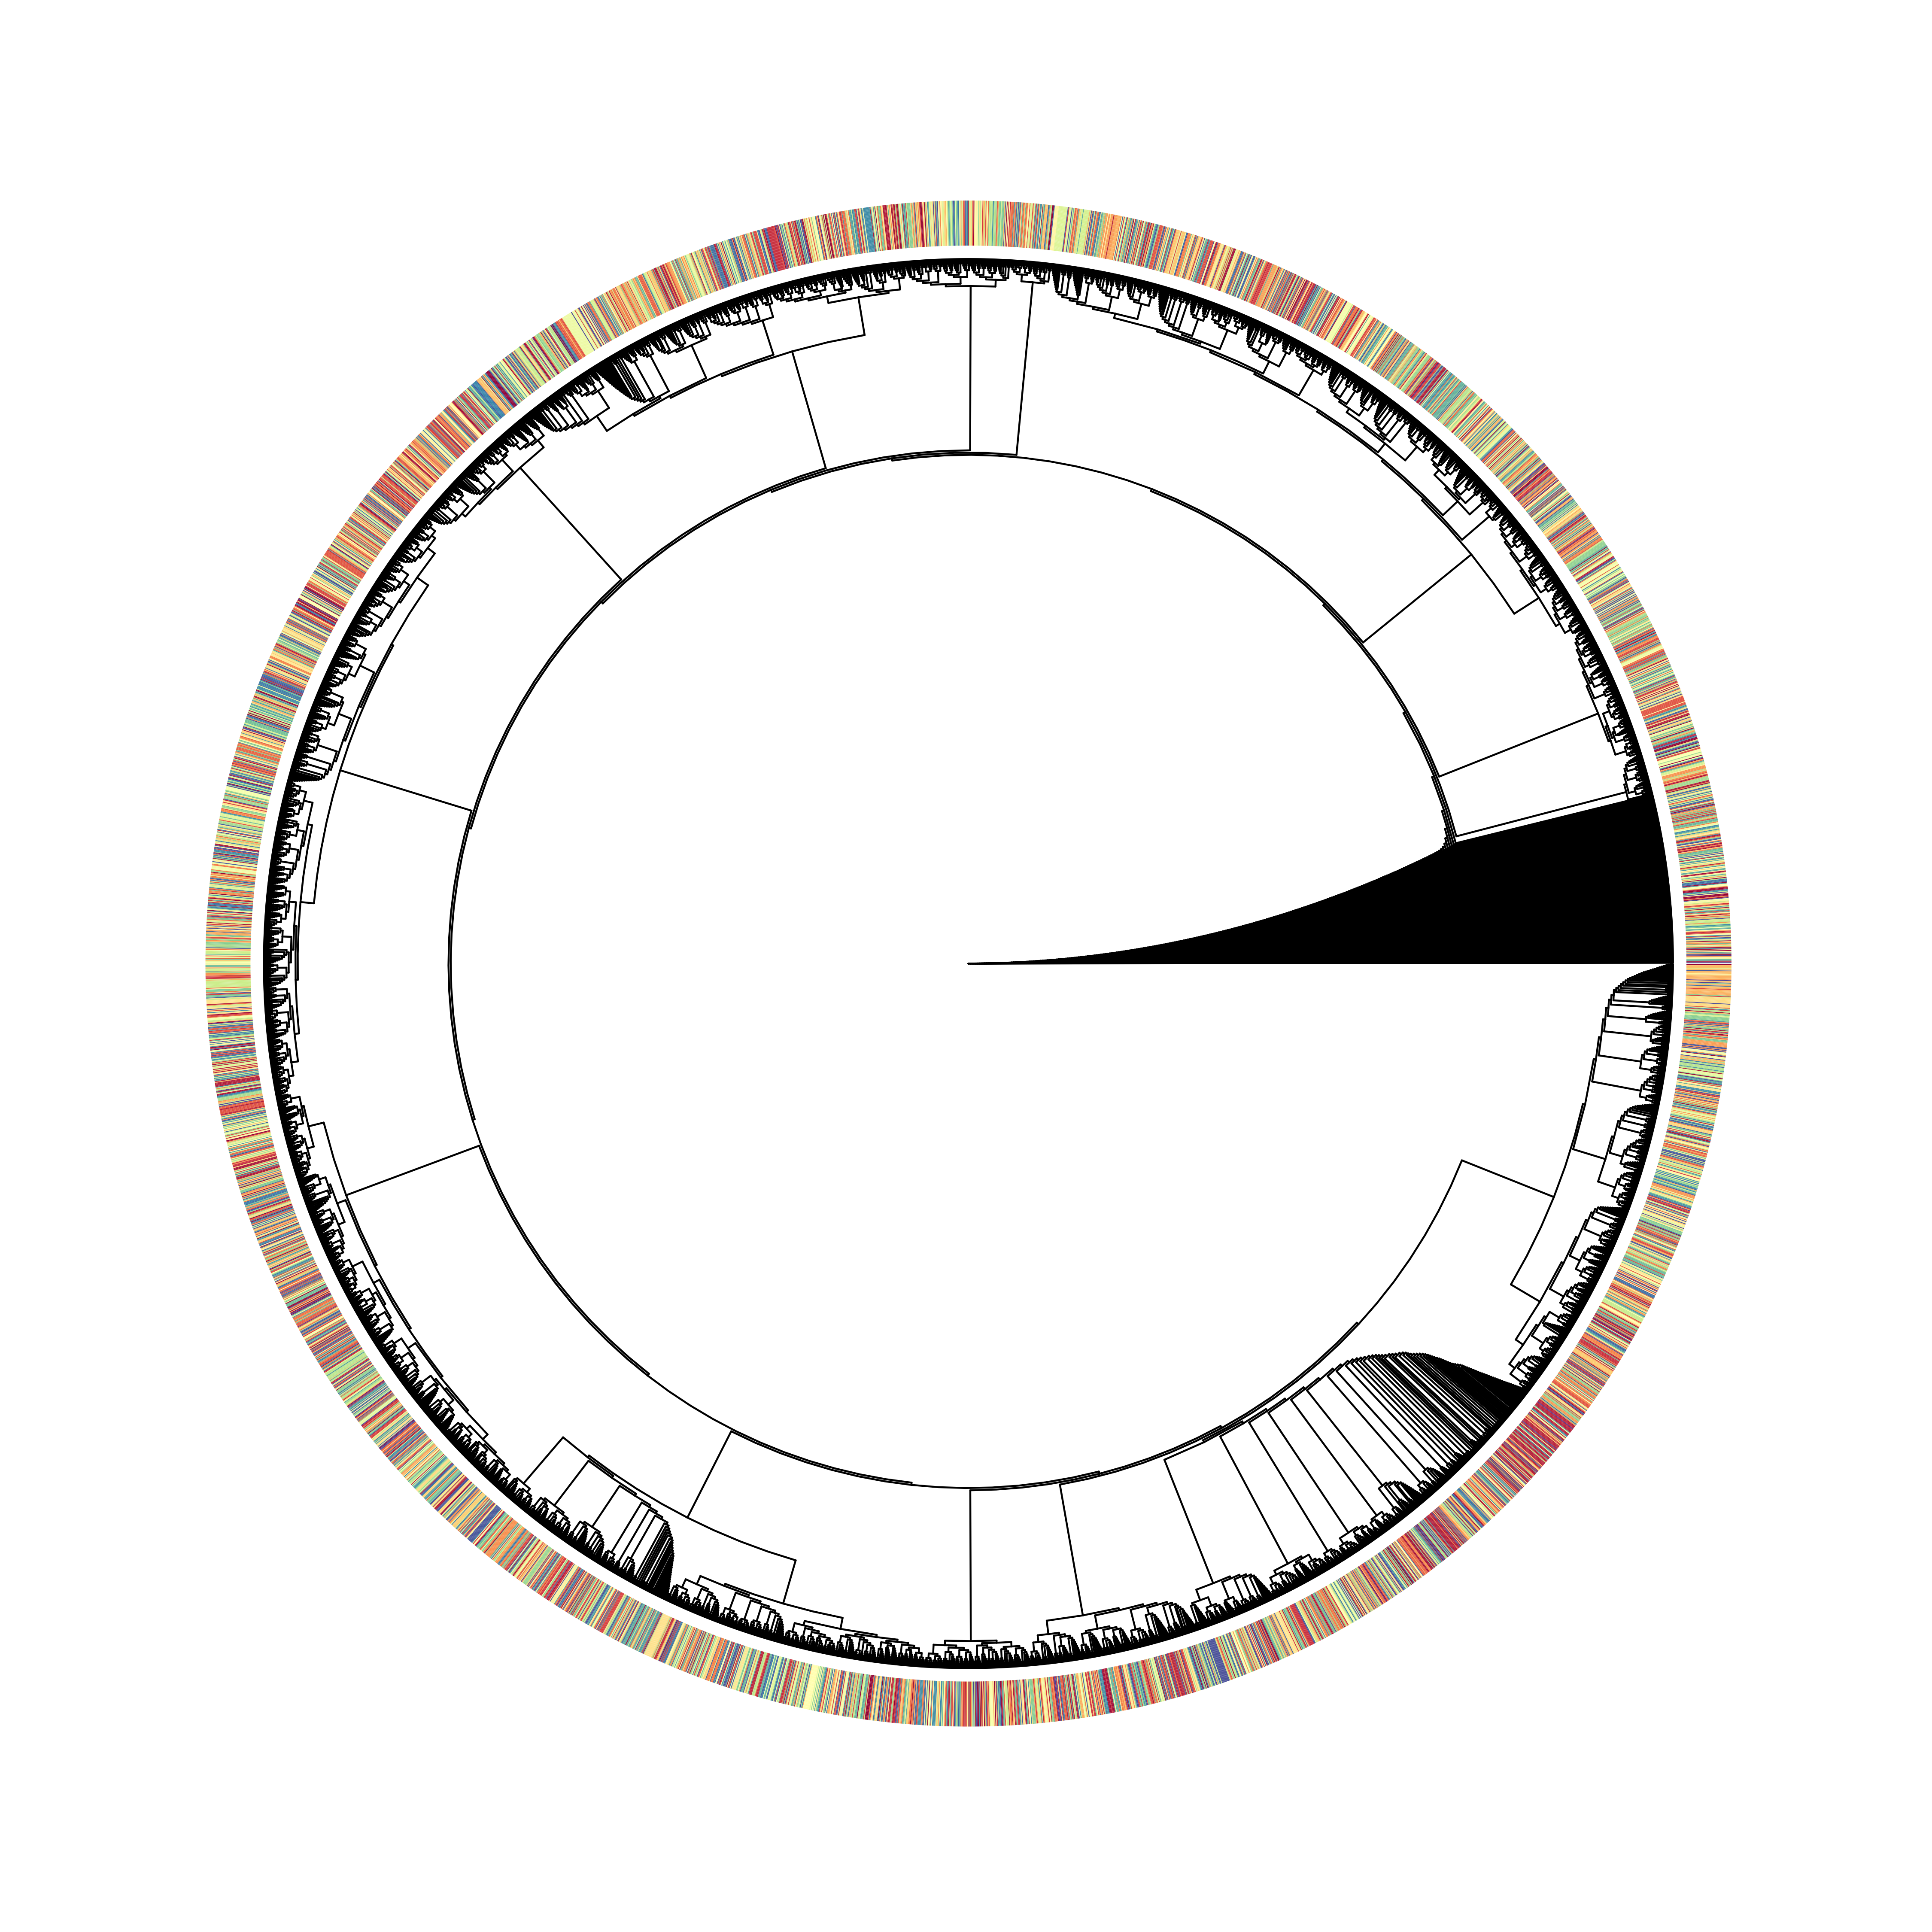

In [22]:
options(repr.plot.width = 15, repr.plot.height = 15, repr.plot.res = 300)

t2 + geom_fruit(
    data=clmdf, 
    geom=geom_tile, 
    mapping=aes(y=Cell,x=2,fill=val), 
    pwidth=0.001, 
    width=20, 
    offset=0.05
    ) + scale_fill_gradientn(colors = jdb_palette("brewer_spectra")) + theme(legend.position = "none")

In [59]:
1367352/3462648
217838/3462648

[1] 0.3948862

[1] 0.06291081

In [55]:
sum(Cts.Mtx.bin1)
sum(Cts.Mtx.bin2)
sum(Cts.Mtx.bin3)

[1] 88290

[1] 16661

[1] 62508

In [46]:
rowSums(Cts.Mtx.bin1) %>% summary
rowSums(Cts.Mtx.bin3) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   4.000   7.000   9.757  12.000 180.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   3.000   5.000   6.908   9.000 133.000 

In [43]:
Cts.Mtx.bin1 %>% dim
Cts.Mtx.bin3 %>% dim

[1] 9049 6269

[1] 9049 5824

In [40]:
table(colnames(Cts.Mtx.bin1) %in% vars_lmhc)


FALSE  TRUE 
 5824   445 

In [49]:
sum(cell_cell_connectivity1)
sum(cell_cell_connectivity2)
sum(cell_cell_connectivity4)

[1] 594060

[1] 6106

[1] 40686

In [51]:
6106/594060
40686/594060

[1] 0.01027842

[1] 0.06848803

In [ ]:

lapply(c("Young1.T1.BMMC", "Youn2.BMMC", "Old1.BMMC", "Old2.BMMC"), function(x){
  analyze_connectivity_impact(x)
}) %>% rbindlist() %>% data.frame() -> pct_df12

(pct_df12 %>%
  mutate(original = original_connections/n_cells, 
         only1 = connections_wOnly1/n_cells))[,c("id", "original", "only1")]


(pct_df12 %>%
    mutate(original = original_connections/n_cells/n_cells*100, 
           only1 = connections_wOnly1/n_cells/n_cells*100))[,c("id", "original", "only1")]


pX <- pct_df12 %>%
  ggplot(aes(x = id, y = pct_connections_lost)) + 
  geom_bar(stat = "identity", color = "black", fill = "lightgrey", width = 0.6) + 
  pretty_plot(fontsize = 7) + L_border() + 
  scale_y_continuous(expand = c(0,0), limits = c(0, 100)) + 
  labs(x = "", y = "% connectivity lost")
cowplot::ggsave2(pX, file = "../final_plots/connectivity_lost.pdf", width = 1.4, height = 1)


pct_go <-  pct_df12 %>% mutate(Weng = original_connections/n_cells, 
                               zPostFilter = connections_after_filter1/n_cells)

pY <- pct_go[,c("id","Weng", "zPostFilter")] %>%
  reshape2::melt(id.vars = "id") %>% 
  ggplot(aes(x = id, y = value, fill = variable)) + 
  geom_bar(stat = "identity", color = "black", width = 0.6, position = position_dodge2()) + 
  pretty_plot(fontsize = 7) + L_border() + 
  scale_y_continuous(expand = c(0,0), limits = c(0, 70)) + 
  labs(x = "", y = "mean connectivity") + 
  scale_fill_manual(values = c("grey1", "grey")) +
  theme(legend.position = "none")
cowplot::ggsave2(pY, file = "../final_plots/n_connections_more1.pdf", width = 2, height = 1)

#############

boosted_go <-  pct_df12 %>% mutate(Weng = original_connections/n_cells, 
                               zPostMod = connections_wOnly1/n_cells)

pZ <- boosted_go[,c("id","Weng", "zPostMod")] %>%
  reshape2::melt(id.vars = "id") %>% 
  ggplot(aes(x = id, y = value, fill = variable)) + 
  geom_bar(stat = "identity", color = "black", width = 0.6, position = position_dodge2()) + 
  pretty_plot(fontsize = 7) + L_border() + 
  scale_y_continuous(expand = c(0,0), limits = c(0, 400)) + 
  labs(x = "", y = "mean connectivity") + 
  scale_fill_manual(values = c("grey1", "grey")) +
  theme(legend.position = "none")
pZ
cowplot::ggsave2(pZ, file = "../final_plots/n_connections_only1.pdf", width = 2, height = 1)
